# Creating the transport map between the two point clouds.

This notebook is used to compute the the optimal transport map for the two point clouds supported on $\mathtt{SE}(3)$. 

In [1]:
%matplotlib
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science', 'notebook'])

Using matplotlib backend: module://matplotlib_inline.backend_inline


In [2]:
target_pose = jnp.load('data/target_pose.npz')
initial_pose = jnp.load('data/initial_pose_square.npz')
target_pose.files, initial_pose.files

(['pose', 'q_vals', 'depth_image'], ['pose', 'q_vals', 'depth_image'])

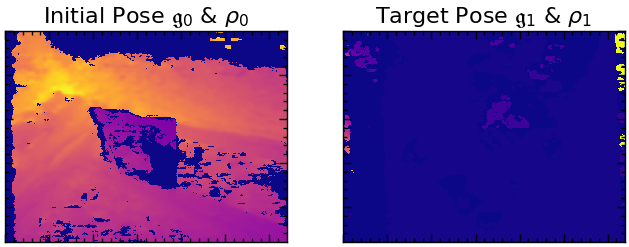

In [10]:
fig, ax = plt.subplots(1,2)

ax[0].set_title(r'Initial Pose $\mathfrak{g}_0$ & $\rho_0$')
ax[0].matshow(initial_pose['depth_image'], cmap=plt.cm.plasma)
ax[0].xaxis.set_tick_params(labeltop=False)
ax[0].yaxis.set_tick_params(labelleft=False)
ax[1].set_title(r'Target Pose $\mathfrak{g}_1$ & $\rho_1$')

pcm = ax[1].matshow(target_pose['depth_image'], cmap=plt.cm.plasma)
ax[1].xaxis.set_tick_params(labeltop=False)
ax[1].yaxis.set_tick_params(labelleft=False)

plt.show()

In [11]:
jnp.amax(initial_pose['depth_image']*0.01), jnp.amax(target_pose['depth_image']*0.01)

(Array(96.77, dtype=float32), Array(655.35, dtype=float32))

In [12]:
initial_pose['depth_image'].shape

(480, 640)

In [13]:
x = jnp.arange(0, 480, 1)
y = jnp.arange(0, 640, 1)
X, Y = jnp.meshgrid(x, y)
X.shape, Y.shape

((640, 480), (640, 480))

In [14]:
# Target pose
target_cloud = 0.01*target_pose['depth_image']
target_pose_se3 = target_pose['pose']

# Initial pose
initial_cloud = 0.01*initial_pose['depth_image']
initial_pose_se3 = initial_pose['pose']

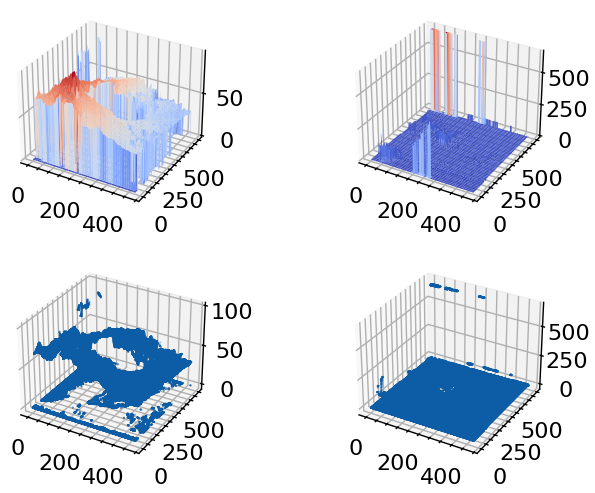

In [8]:
fig, ax = plt.subplots(2,2, subplot_kw={"projection": "3d"})
surf_1 = ax[0,0].plot_surface(X.T, Y.T, 0.01*initial_pose['depth_image'], cmap=plt.cm.coolwarm) # It is multiplied by 0.01cm to turn the raw depth map into something readable
surf_2 = ax[0,1].plot_surface(X.T, Y.T, 0.01*target_pose['depth_image'], cmap=plt.cm.coolwarm)
scatter_1 = ax[1,0].scatter(X, Y, initial_cloud.T, s=0.1)
scatter_2 = ax[1,1].scatter(X, Y, target_cloud.T, s=0.1)

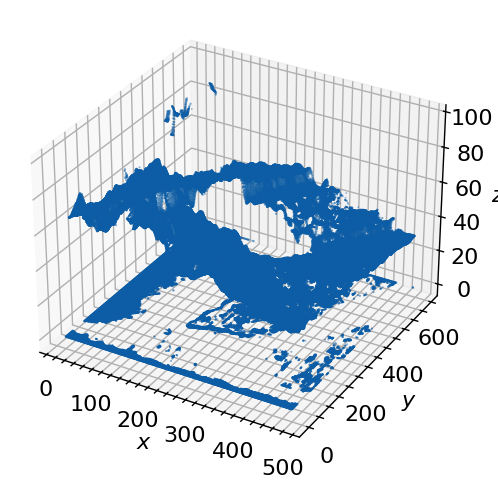

In [9]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(X, Y, initial_cloud.T, s=0.1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
plt.show()

Now that we can plot the data in both surface and scatter plot form, we want to see if we can use the `ott-jax` library to compute the optimal transport map between the initial and target poses. Once we have that, we can look at computing controllability matrices. 

In [15]:
import ott
from ott.geometry import costs, pointcloud
from ott import utils
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
from ott.tools import plot
from tqdm.notebook import trange, tqdm

An important thing here is the representation of the point cloud in some 3D array. The ground cost can be added as well, such that we include the geodesic distance $d(\mathfrak{g}_0, \mathfrak{g}_1)$.  

In [16]:
g_0 = jnp.vstack([X.ravel(), Y.ravel(), initial_cloud.T.ravel()]).T
g_1 = jnp.vstack([X.ravel(), Y.ravel(), target_cloud.T.ravel()]).T
g_0.shape, g_1.shape

((307200, 3), (307200, 3))

In [20]:
geom = pointcloud.PointCloud(g_0[0:10000,:], g_1[0:10000,:], epsilon=1e-3)
geom.cost_matrix.shape

(10000, 10000)

In [21]:
tau = 0.9
ot_prob = linear_problem.LinearProblem(geom, tau_a=tau, tau_b=tau)
with tqdm(ncols='500px') as pbar:
    progress_fn = utils.tqdm_progress_fn(pbar)
    solver = sinkhorn.Sinkhorn(progress_fn=progress_fn)
    ot = jax.jit(solver)(ot_prob)
    
print(
    " Sinkhorn has converged: ",
    ot.converged,
    "\n",
    "Error upon last iteration: ",
    ot.errors[(ot.errors > -1)][-1],
    "\n",
    "Sinkhorn required ",
    jnp.sum(ot.errors > -1),
    " iterations to converge. \n",
    "Entropy regularized OT cost: ",
    ot.ent_reg_cost,
    "\n",
    "OT cost (without entropy): ",
    jnp.sum(ot.matrix * ot.geom.cost_matrix),
)

0it [00:00, ?it/s]

 Sinkhorn has converged:  True 
 Error upon last iteration:  0.00029602088 
 Sinkhorn required  4  iterations to converge. 
 Entropy regularized OT cost:  -0.0093047125 
 OT cost (without entropy):  2.614539e-26


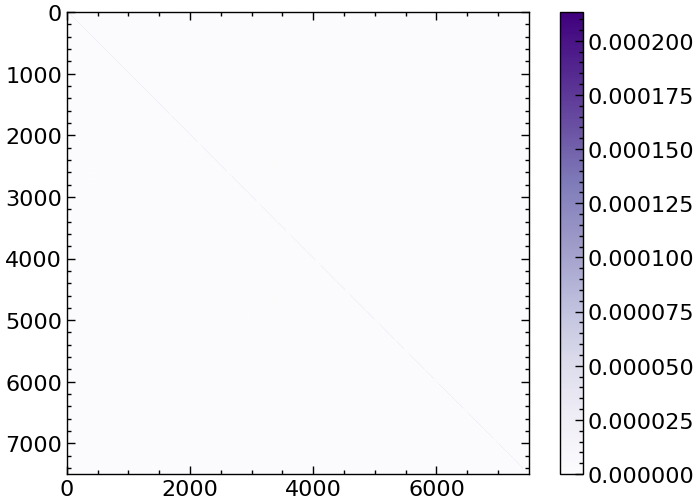

In [23]:
P = ot.matrix
plt.imshow(P, cmap="Purples")
plt.colorbar();

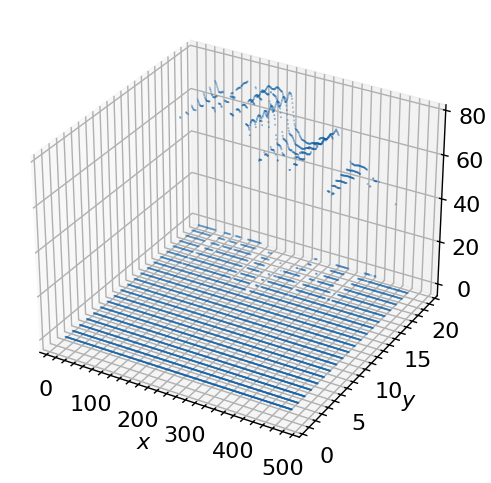

In [22]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(g_0[0:10000,0], g_0[0:10000,1], g_0[0:10000,2], s=0.1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
plt.show()